In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import ModelClass

from matplotlib import pyplot as plt
import seaborn as sns
#from sklearnex import patch_sklearn
#patch_sklearn(verbose=False)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor


In [2]:
# Included in separate cell in case cat boost is not installed.
from catboost import CatBoostClassifier

In [3]:
X = pd.read_csv('data/Training-set-values.csv')
y = pd.read_csv('data/Training-set-labels.csv')

X['date_recorded'] = pd.to_datetime(X['date_recorded']).astype(np.int64)

#### Preprocessors

In [4]:
# Super basic numeric transformer

numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median'))]
)

numeric_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, make_column_selector(dtype_include=np.number)),
    ]
)

### Models

In [5]:
# Gradient Boost
GradBoost = {'classifier': GradientBoostingClassifier(),'preprocessor': numeric_preprocessor}
GradBoost2 = {'classifier': GradientBoostingClassifier(),'preprocessor': None}
GradBoost3 = {'classifier': GradientBoostingClassifier(),'preprocessor': None}
# XGradient Boosting
XGBoost = {'classifier': XGBRegressor(objective='reg:squarederror'), 'preprocessor': numeric_preprocessor}
# CatBoost
CatBoost = {'classifier': CatBoostClassifier(max_depth=3),'preprocessor': numeric_preprocessor}



models = {'GradientBoost': GradBoost,
    'GradientBoost2': GradBoost2,
    'GradientBoost3': GradBoost3,
    'XGBoost': XGBoost,
    'CatBoost': CatBoost
    }


### Modeler

In [6]:
model_run = ModelClass.Modeler(models, X=X, y=y)

# after the model_run object is created so we can add onto the default preprocessor.
log_reg_regularized = {'classifier': LogisticRegression(n_jobs=3), 'preprocessor': model_run.create_default_prep(num_add=[('scaling', StandardScaler())])}
model_run.add_model('log_reg_regularized', log_reg_regularized)

### Search parameters and kwargs

In [7]:
GradBoost_params = dict(n_estimators=np.array(range(100, 400)),
                    criterion=['friedman_mse', 'squared_error'],
                    max_depth=np.array(range(2, 10)),
                    min_samples_split=np.array(range(2, 10)),
                    min_samples_leaf=np.array(range(1, 10)),
                    learning_rate=stats.uniform(loc=0.01, scale=1))

GradBoost3_params = dict(n_estimators=np.array(range(200, 1000)),
                    criterion=['friedman_mse', 'squared_error'],
                    max_depth=np.array(range(2, 10)),
                    min_samples_split=np.array(range(2, 10)),
                    min_samples_leaf=np.array(range(1, 10)),
                    learning_rate=stats.uniform(loc=0.001, scale=1))

XGBoost_params = dict(learning_rate =stats.uniform(loc=0.1, scale=0.1),
                    n_estimators=np.array(range(100,1200)),
                    max_depth=np.array(range(4,30)))

CatBoost_params = dict(max_depth =[3,4,5],
                         n_estimators = [100,200,300])

search_options = {'n_jobs': 3, 'random_state': 9280210, 'n_iter': 20}

## RandomizedSearchCV

In [8]:
model_run.hyper_search('GradientBoost', params=GradBoost_params, searcher_kwargs=search_options, set_to_train=True)

In [9]:
model_run.hyper_search('GradientBoost2', params=GradBoost_params, searcher_kwargs=search_options, set_to_train=True)

/Users/valeriaviscarra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [10]:
model_run.hyper_search('GradientBoost3', params=GradBoost3_params, searcher_kwargs=search_options, set_to_train=True)

In [11]:
model_run.hyper_search('XGBoost', params=XGBoost_params, searcher_kwargs=search_options, set_to_train=True)

/Users/valeriaviscarra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [12]:
model_run.hyper_search('CatBoost', params=CatBoost_params, searcher_kwargs=search_options, set_to_train=True)

/Users/valeriaviscarra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Learning rate set to 0.265612
0:	learn: 0.9862021	total: 78.3ms	remaining: 23.4s
1:	learn: 0.9216414	total: 84.4ms	remaining: 12.6s
2:	learn: 0.8824521	total: 90.1ms	remaining: 8.92s
3:	learn: 0.8555248	total: 95.7ms	remaining: 7.08s
4:	learn: 0.8364673	total: 101ms	remaining: 5.96s
5:	learn: 0.8218166	total: 106ms	remaining: 5.17s
6:	learn: 0.8129340	total: 112ms	remaining: 4.69s
7:	learn: 0.8058792	total: 118ms	remaining: 4.31s
8:	learn: 0.7989142	total: 123ms	remaining: 3.99s
9:	learn: 0.7937780	total: 129ms	remaining: 3.73s
10:	learn: 0.7907538	total: 134ms	remaining: 3.52s
11:	learn: 0.7854812	total: 139ms	remaining: 3.35s
12:	learn: 0.7833159	total: 145ms	remaining: 3.2s
13:	learn: 0.7807781	total: 150ms	remaining: 3.06s
14:	learn: 0.7768205	total: 155ms	remaining: 2.95s
15:	learn: 0.7742835	total: 162ms	remaining: 2.87s
16:	learn: 0.7717098	total: 168ms	remaining: 2.8s
17:	learn: 0.7701826	total: 173ms	remaining: 2.71s
18:	learn: 0.7680539	total: 180ms	remaining: 2.65s
19:	learn

## Test Models

In [13]:
# Gradient Boost
gb_model=model_run.get_model('GradientBoost')['model_pipeline']
Gradient_Boost = gb_model.score(X=model_run._X_test, y=model_run._y_test)
Gradient_Boost

0.7105723905723905

In [14]:
# Gradient Boost 2
gb2_model= model_run.get_model('GradientBoost2')['model_pipeline']
Gradient_Boost2 = gb2_model.score(X=model_run._X_test, y=model_run._y_test)
Gradient_Boost2 

0.8061279461279461

In [15]:
# Gradient Boost 3
gb3_model= model_run.get_model('GradientBoost3')['model_pipeline']
Gradient_Boost3 = gb3_model.score(X=model_run._X_test, y=model_run._y_test)
Gradient_Boost3 

0.8054545454545454

In [16]:
# XGBoost
xgb_model= model_run.get_model('XGBoost')['model_pipeline']
XG_Boost = xgb_model.score(X=model_run._X_test, y=model_run._y_test)
XG_Boost

0.29846332133089515

In [17]:
# CatBoost
cb_model= model_run.get_model('CatBoost')['model_pipeline']
Cat_Boost = cb_model.score(X=model_run._X_test, y=model_run._y_test)
Cat_Boost

0.6808754208754209

In [18]:
boost_models = {'Gradient_Boost': 0.705993265993266,
    'Gradient_Boost2': 0.8046464646464646,
    'Gradient_Boost3': 0.8052525252525252,
    'XG_Boost': 0.29846332133089515,
    'Cat_Boost': 0.6808754208754209
    }

## Modeler

### Model 1

In [21]:
model_run.train_model('GradientBoost2', cv=False)

root - INFO - GradientBoost2 has been fit.


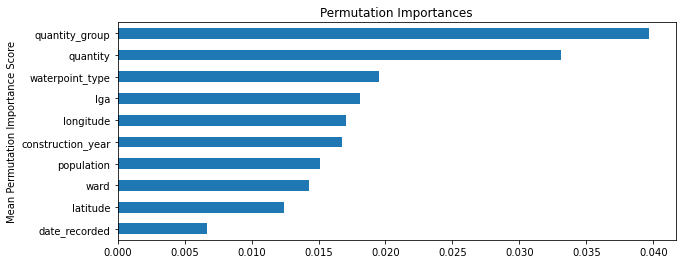

In [23]:
importance_kwargs = dict(n_repeats=10, n_jobs=3)
model_run.permutation_importance('GradientBoost2', perm_kwargs=importance_kwargs)

### Model 2

In [29]:
model_run.train_model('GradientBoost3', cv=False)

root - INFO - GradientBoost3 has been fit.


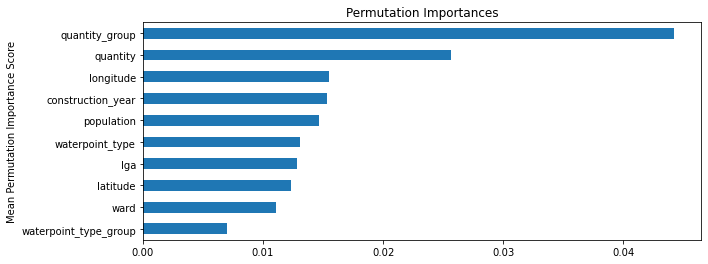

In [30]:
importance_kwargs = dict(n_repeats=10, n_jobs=3)
model_run.permutation_importance('GradientBoost3', perm_kwargs=importance_kwargs)